# Stability Fine-Tuning REST API - Dev Test

Thank you for trying the first external beta of the Stability Fine-Tuning service! Note that this is a **developer beta** - bugs and quality issues with the generated fine-tunes may occur. Please reach out to Stability if this is the case - and share what you've made as well!

The code below hits the Stability REST API.  This REST API contract is rather solid, so it's unlikely to see large changes before the production release of fine-tuning.

Known issues:

* Style fine-tunes may result in overfitting - if this is the case, uncomment the `# weight=1.0` field of `DiffusionFineTune` in the diffusion section and provide a value between -1 and 1. You may need to go as low as 0.2 or 0.1.
* We will be exposing test parameters soon - please reach out with examples of datasets that produce overfitting or errors if you have them.


In [ ]:
#@title Add your API key
import getpass

#@markdown > Execute this step and paste your API key in the box that appears. <br/> <br/> Visit https://next.platform-stability.pages.dev/account/keys to get your API key! <br/> <em>Note: If you are not on the fine-tuning whitelist you will receive an error during training.</em>

API_KEY = getpass.getpass('Paste your Stability API Key here and press Enter: ')
API_HOST = "https://staging-api.stability.ai"

engine_id = "stable-diffusion-xl-1024-v1-0"

In [31]:
#@title Initialize the Fine-Tuning REST API wrapper

import io
import logging
import requests
import os
import shutil
import sys
import time
import json
import base64
from enum import Enum
from dataclasses import dataclass, is_dataclass, field, asdict
from typing import List, Optional, Any
from IPython.display import clear_output
from pathlib import Path
from PIL import Image
from zipfile import ZipFile


class Printable:
    """ Helper class for printing a class to the console. """

    @staticmethod
    def to_json(obj: Any) -> Any:
        if isinstance(obj, Enum):
            return obj.value
        if is_dataclass(obj):
            return asdict(obj)

        return obj

    def __str__(self):
        return f"{self.__class__.__name__}: {json.dumps(self, default=self.to_json, indent=4)}"


class ToDict:
    """ Helper class to simplify converting dataclasses to dicts. """

    def to_dict(self):
        return {k: v for k, v in asdict(self).items() if v is not None}


@dataclass
class FineTune(Printable):
    id: str
    user_id: str
    name: str
    mode: str
    engine_id: str
    training_set_id: str
    status: str
    failure_reason: Optional[str] = field(default=None)
    duration_seconds: Optional[int] = field(default=None)
    object_prompt: Optional[str] = field(default=None)


@dataclass
class DiffusionFineTune(Printable, ToDict):
    id: str
    token: str
    weight: Optional[float] = field(default=None)


@dataclass
class TextPrompt(Printable, ToDict):
    text: str
    weight: Optional[float] = field(default=None)


class Sampler(Enum):
    DDIM = "DDIM"
    DDPM = "DDPM"
    K_DPMPP_2M = "K_DPMPP_2M"
    K_DPMPP_2S_ANCESTRAL = "K_DPMPP_2S_ANCESTRAL"
    K_DPM_2 = "K_DPM_2"
    K_DPM_2_ANCESTRAL = "K_DPM_2_ANCESTRAL"
    K_EULER = "K_EULER"
    K_EULER_ANCESTRAL = "K_EULER_ANCESTRAL"
    K_HEUN = "K_HEUN"
    K_LMS = "K_LMS"

    @staticmethod
    def from_string(val) -> Enum or None:
        for sampler in Sampler:
            if sampler.value == val:
                return sampler
        raise Exception(f"Unknown Sampler: {val}")


@dataclass
class TextToImageParams(Printable):
    fine_tunes: List[DiffusionFineTune]
    text_prompts: List[TextPrompt]
    samples: int
    sampler: Sampler
    engine_id: str
    steps: int
    seed: Optional[int] = field(default=0)
    cfg_value: Optional[int] = field(default=7)
    width: Optional[int] = field(default=1024)
    height: Optional[int] = field(default=1024)


@dataclass
class DiffusionResult:
    base64: str
    seed: int
    finish_reason: str

    def __str__(self):
        return f"DiffusionResult(base64='too long to print', seed='{self.seed}', finish_reason='{self.finish_reason}')"

    def __repr__(self):
        return self.__str__()


@dataclass
class TrainingSetBase(Printable):
    id: str
    name: str


@dataclass
class TrainingSetImage(Printable):
    id: str


@dataclass
class TrainingSet(TrainingSetBase):
    images: List[TrainingSetImage]


class FineTuningRESTWrapper:
    """
    Helper class to simplify interacting with the Stability REST API.

    Your application should probably have a more robust service (retries, etc.), but
    this is a good starting point.
    """

    def __init__(self, api_key: str, api_host: str):
        self.api_key = api_key
        self.api_host = api_host

    def create_fine_tune(self,
                         name: str,
                         images: List[str],
                         engine_id: str,
                         mode: str,
                         object_prompt: Optional[str] = None) -> FineTune:
        print(f"Creating {mode} fine-tune called '{name}' using {len(images)} images...")

        payload = {"name": name, "engine_id": engine_id, "mode": mode}
        if object_prompt is not None:
            payload["object_prompt"] = object_prompt

        # Create a training set
        training_set_id = self.create_training_set(name=name)
        payload["training_set_id"] = training_set_id
        print(f"\tCreated training set {training_set_id}")

        for image in images:
            print(f"\t\tAdding {os.path.basename(image)}")
            self.add_image_to_training_set(
                training_set_id=training_set_id,
                image=image
            )

        print(f"\tCreating a fine-tune from the training set")
        response = requests.post(
            f"{self.api_host}/v1/fine-tunes",
            json=payload,
            headers={
                "Authorization": self.api_key,
                "Content-Type": "application/json"
            }
        )
        raise_on_non200(response)
        print(f"\tCreated fine-tune {response.json()['id']}")

        print(f"Success")
        return FineTune(**response.json())

    def get_fine_tune(self, fine_tune_id: str) -> FineTune:
        response = requests.get(
            f"{self.api_host}/v1/fine-tunes/{fine_tune_id}",
            headers={"Authorization": self.api_key}
        )

        raise_on_non200(response)

        return FineTune(**response.json())

    def list_fine_tunes(self) -> List[FineTune]:
        response = requests.get(
            f"{self.api_host}/v1/fine-tunes",
            headers={"Authorization": self.api_key}
        )

        raise_on_non200(response)

        return [FineTune(**ft) for ft in response.json()]

    def rename_fine_tune(self, fine_tune_id: str, name: str) -> FineTune:
        response = requests.patch(
            f"{self.api_host}/v1/fine-tunes/{fine_tune_id}",
            json={"operation": "RENAME", "name": name},
            headers={
                "Authorization": self.api_key,
                "Content-Type": "application/json"
            }
        )

        raise_on_non200(response)

        return FineTune(**response.json())

    def retrain_fine_tune(self, fine_tune_id: str) -> FineTune:
        response = requests.patch(
            f"{self.api_host}/v1/fine-tunes/{fine_tune_id}",
            json={"operation": "RETRAIN"},
            headers={
                "Authorization": self.api_key,
                "Content-Type": "application/json"
            }
        )

        raise_on_non200(response)

        return FineTune(**response.json())

    def delete_fine_tune(self, fine_tune: FineTune):
        # Delete the underlying training set
        self.delete_training_set(fine_tune.training_set_id)

        # Delete the fine-tune
        response = requests.delete(
            f"{self.api_host}/v1/fine-tunes/{fine_tune.id}",
            headers={"Authorization": self.api_key}
        )

        raise_on_non200(response)

    def create_training_set(self, name: str) -> str:
        response = requests.post(
            f"{self.api_host}/v1/training-sets",
            json={"name": name},
            headers={
                "Authorization": self.api_key,
                "Content-Type": "application/json"
            }
        )

        raise_on_non200(response)

        return response.json().get('id')

    def get_training_set(self, training_set_id: str) -> TrainingSet:
        response = requests.get(
            f"{self.api_host}/v1/training-sets/{training_set_id}",
            headers={"Authorization": self.api_key}
        )

        raise_on_non200(response)

        return TrainingSet(**response.json())

    def list_training_sets(self) -> List[TrainingSetBase]:
        response = requests.get(
            f"{self.api_host}/v1/training-sets",
            headers={"Authorization": self.api_key}
        )

        raise_on_non200(response)

        return [TrainingSetBase(**tsb) for tsb in response.json()]

    def add_image_to_training_set(self, training_set_id: str, image: str) -> None:
        with open(image, 'rb') as image_file:
            response = requests.post(
                f"{self.api_host}/v1/training-sets/{training_set_id}/images",
                headers={"Authorization": self.api_key},
                files={'image': image_file}
            )

        raise_on_non200(response)

    def remove_image_from_training_set(self, training_set_id: str, image_id: str) -> None:
        response = requests.delete(
            f"{self.api_host}/v1/training-sets/{training_set_id}/images/{image_id}",
            headers={"Authorization": self.api_key}
        )

        raise_on_non200(response)

    def delete_training_set(self, training_set_id: str) -> None:
        response = requests.delete(
            f"{self.api_host}/v1/training-sets/{training_set_id}",
            headers={"Authorization": self.api_key}
        )

        raise_on_non200(response)

    def text_to_image(self, params: TextToImageParams) -> List[DiffusionResult]:
        payload = {
            "fine_tunes": [ft.to_dict() for ft in params.fine_tunes],
            "text_prompts": [tp.to_dict() for tp in params.text_prompts],
            "samples": params.samples,
            "sampler": params.sampler.value,
            "steps": params.steps,
            "seed": params.seed,
            "width": params.width,
            "height": params.height,
            "cfg_value": params.cfg_value,
        }

        response = requests.post(
            f"{self.api_host}/v1/generation/{params.engine_id}/text-to-image",
            json=payload,
            headers={
                "Authorization": self.api_key,
                "Accept": "application/json",
            }
        )

        raise_on_non200(response)

        return [
            DiffusionResult(base64=item["base64"], seed=item["seed"], finish_reason=item["finishReason"])
            for item in response.json()["artifacts"]
        ]


def raise_on_non200(response):
    if 200 <= response.status_code < 300:
        return
    raise Exception(f"Status code {response.status_code}: {json.dumps(response.json(), indent=4)}")


# Redirect logs to print statements so we can see them in the notebook
class PrintHandler(logging.Handler):
    def emit(self, record):
        print(self.format(record))
logging.getLogger().addHandler(PrintHandler())
logging.getLogger().setLevel(logging.INFO)

# Initialize the fine-tune service
rest_api = FineTuningRESTWrapper(API_KEY, API_HOST)

In [22]:
#@title List fine-tunes for this user / organization.
fine_tunes = rest_api.list_fine_tunes()
print(f"Found {len(fine_tunes)} models")
for fine_tune in fine_tunes:
    print(f"  Model {fine_tune.id} {fine_tune.status:<9} {fine_tune.name}")

Found 50 models
  Model 09672d5c-2e91-42a7-b620-42bc1bd100f8 COMPLETED e2e-eugene-1694810277804
  Model 582e9223-e05a-4794-b6c4-3a44c92440f3 COMPLETED eugene-3
  Model 94ccd82e-d29f-4399-af3a-e45b282678a0 COMPLETED eugene-4
  Model 59b9e2c9-9252-403c-9b65-a77d9595762d COMPLETED eugene-5-scaled
  Model 66296ce3-c574-4b98-8203-af93e8439057 COMPLETED eugene-7-raw
  Model 1856e125-e152-4469-9416-e6ba5e7bb4c0 FAILED    e2e-eugene-1695063380535
  Model 14dbeba2-842a-4c64-81b9-f7c0169f993f FAILED    e2e-eugene-1695063708895
  Model 150412ca-6591-4a33-8a72-2e4e53699276 FAILED    my awesome fine-tune
  Model 675d2270-f5ac-4182-b2cb-a9a0cc06f0c2 COMPLETED e2e-eugene-1695063182374
  Model 97ea4136-9c7a-49f5-bcd6-7a8c7cf94f84 COMPLETED e2e-eugene-1695063621974
  Model 406999b6-6353-4581-a599-f595fa1c45db COMPLETED e2e-eugene-1695063908950
  Model 6b0a7f1d-81ea-4263-82c8-1b0f0d52dc3c COMPLETED e2e-test-fine-tune
  Model 8891e833-81a3-4077-b69c-1167144de8e5 COMPLETED e2e-eugene-1695146009815
  Model

# Dataset uploading

For training, we need a dataset of images in a `.zip` file.

<em>Please only upload images that you have the permission to use.</em>


### Dataset image dimensions

- Images **cannot** have any side less than 328px
- Images **cannot** be larger than 10MB

There is no upper-bound for what we'll accept for an image's dimensions, but any side above 1024px will be scaled down to 1024px, while preserving aspect ratio. For example:
- `3024x4032` will be scaled down to `768x1024`
- `1118x1118` will be scaled down to `1024x1024`


### Dataset size

- Datasets **cannot** have fewer than 3 images
- Datasets **cannot** have more than 64 images

A larger dataset often tends to result in a more accurate fine-tune, but will also take longer to train.

While each mode can accept up to 64 images, we have a few suggestions for a starter dataset based on the mode you are using:
*   `FACE`: 6 or more images.
*   `OBJECT`: 6 - 10 images.
*   `STYLE`: 20 - 30 images.



In [24]:
#@title Upload ZIP file of images
training_dir = "./train"
Path(training_dir).mkdir(exist_ok=True)
try:
    from google.colab import files

    upload_res = files.upload()
    print(upload_res.keys())
    extracted_dir = list(upload_res.keys())[0]
    print(f"Received {extracted_dir}")
    if not extracted_dir.endswith(".zip"):
        raise ValueError("Uploaded file must be a zip file")

    zf = ZipFile(io.BytesIO(upload_res[extracted_dir]), "r")
    extracted_dir = Path(extracted_dir).stem
    print(f"Extracting to {extracted_dir}")
    zf.extractall(extracted_dir)

    for root, dirs, files in os.walk(extracted_dir):
        for file in files:
            source_path = os.path.join(root, file)
            target_path = os.path.join(training_dir, file)

            if 'MACOSX' in source_path or 'DS' in source_path:
              continue
            print('Copying', source_path, '==>', target_path)
            # Move the file to the target directory
            shutil.move(source_path, target_path)


except ImportError:
    pass

print(f"Using training images from: {training_dir}")

Saving eugene.zip to eugene (1).zip
dict_keys(['eugene (1).zip'])
Received eugene (1).zip
Extracting to eugene (1)
Copying eugene (1)/eugene/IMG_6207.jpeg ==> ./train/IMG_6207.jpeg
Copying eugene (1)/eugene/IMG_5738.jpeg ==> ./train/IMG_5738.jpeg
Copying eugene (1)/eugene/IMG_5748.jpeg ==> ./train/IMG_5748.jpeg
Copying eugene (1)/eugene/IMG_6197.jpeg ==> ./train/IMG_6197.jpeg
Copying eugene (1)/eugene/IMG_6336.jpeg ==> ./train/IMG_6336.jpeg
Copying eugene (1)/eugene/IMG_6202.jpeg ==> ./train/IMG_6202.jpeg
Copying eugene (1)/eugene/IMG_5700.jpeg ==> ./train/IMG_5700.jpeg
Using training images from: ./train


# Let the training begin!

Now we're ready to train our fine-tune. Use the parameters below to configure the name and the kind of fine-tune

Please note that the training duration will vary based on:
- The number of images in your dataset
- The `training_mode` used
- The `engine_id` that is being fine-tuned on

However, the following are some rough estimates for the training duration for each mode based on our recommended dataset sizes:

* `FACE`: 4 - 5 minutes.
* `OBJECT`: 5 - 10 minutes.
* `STYLE`: 20 - 30 minutes.


In [25]:
#@title Create a fine-tune and begin training
fine_tune_name = "my dog spot" #@param {type:"string"}
#@markdown > Requirements: <ul><li>Must be unique (only across your account, not globally)</li> <li>Must be between 3 and 64 characters (inclusive)</li> <li>Must only contain letters, numbers, spaces, or hyphens</li></ul>
training_mode = "OBJECT" #@param ["FACE", "STYLE", "OBJECT"] {type:"string"}
#@markdown > Determines the kind of fine-tune you're creating: <ul><li><code>FACE</code> - a fine-tune on faces; expects pictures containing a face; automatically crops and centers on the face detected in the input photos.</li> <li> <code>OBJECT</code> - a fine-tune on a particular object (e.g. a bottle); segments out the object using the `object_prompt` below</li> <li><code>STYLE</code> - a fine-tune on a particular style (e.g. satellite photos of earth); crops the images and filters for image quality.</li></ul>
object_prompt = "dog" #@param {type:"string"}
#@markdown > Used for segmenting out your subject when the `training_mode` is `OBJECT`.  (i.e. if you want to fine tune on a cat, put `cat` - for a bottle of liquor, use `bottle`. In general, it's best to use the most general word you can to describe your object.)

# Gather training images
images = []
for filename in os.listdir(training_dir):
    if os.path.splitext(filename)[1].lower() in ['.png', '.jpg', '.jpeg', '.heic']:
        images.append(os.path.join(training_dir, filename))

# Create the fine-tune
fine_tune = rest_api.create_fine_tune(
    name=fine_tune_name,
    images=images,
    mode=training_mode,
    object_prompt=object_prompt if training_mode == "OBJECT" else None,
    engine_id=engine_id,
)

print()
print(fine_tune)

Creating OBJECT fine-tune called 'my dawg eugene' using 7 images...
	Created training set 536d9faf-dc8c-4118-83b2-6ae5c1bdceae
		Adding IMG_6207.jpeg
		Adding IMG_5738.jpeg
		Adding IMG_5748.jpeg
		Adding IMG_6197.jpeg
		Adding IMG_6336.jpeg
		Adding IMG_6202.jpeg
		Adding IMG_5700.jpeg
	Creating a fine-tune from the training set
Success - created fine-tune 0cda68d0-1d24-4a0f-a889-5a9198ba90f6

FineTune: {
    "id": "0cda68d0-1d24-4a0f-a889-5a9198ba90f6",
    "user_id": "user-T7rEwI3fgRGxIruUkmdev8VV",
    "name": "my dawg eugene",
    "mode": "OBJECT",
    "engine_id": "stable-diffusion-xl-1024-v1-0",
    "training_set_id": "536d9faf-dc8c-4118-83b2-6ae5c1bdceae",
    "status": "SUBMITTED",
    "failure_reason": null,
    "duration_seconds": null,
    "object_prompt": "dog"
}


In [27]:
#@title Check on training status
start_time = time.time()
while fine_tune.status != "COMPLETED" and fine_tune.status != "FAILED":
    fine_tune = rest_api.get_fine_tune(fine_tune.id)
    elapsed = time.time() - start_time
    clear_output(wait=True)
    print(f"Training '{fine_tune.name}' ({fine_tune.id}) status: {fine_tune.status} for {elapsed:.0f} seconds")
    time.sleep(10)

clear_output(wait=True)
status_message = "completed" if fine_tune.status == "COMPLETED" else "failed"
print(f"Training '{fine_tune.name}' ({fine_tune.id}) {status_message} after {elapsed:.0f} seconds")

Training 'my dawg eugene' (0cda68d0-1d24-4a0f-a889-5a9198ba90f6) completed after 1111 seconds


In [ ]:
#@title If training fails for some reason, you can resubmit the fine-tune
if fine_tune.status == "FAILED":
    print(f"Training failed, due to {fine_tune.failure_reason}. Retraining...")
    fine_tune = rest_api.retrain_fine_tune(fine_tune.id)

Diffusion completed in 22 seconds!
The 1 results will be displayed below momentarily (depending on the speed of Colab).



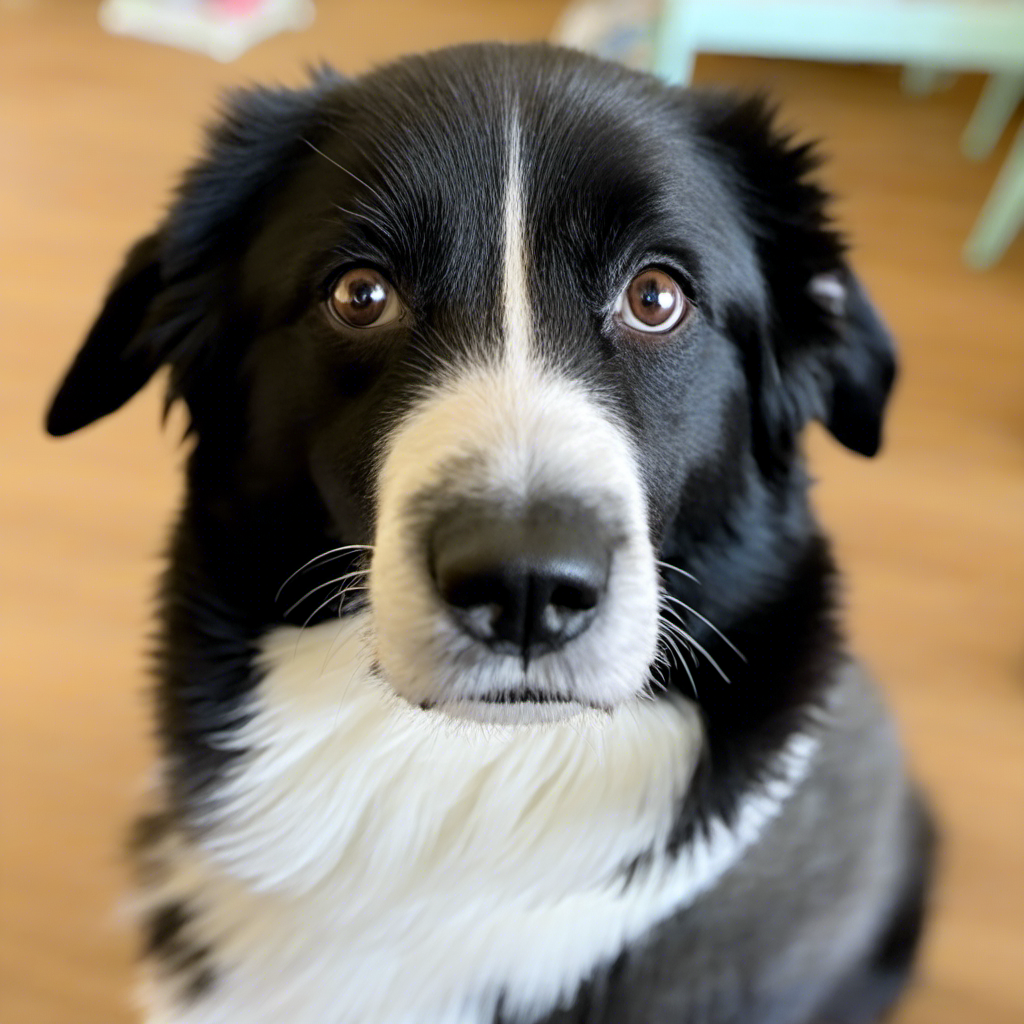

In [30]:
#@title <font color="#FFFFFF">Diffuse with your fine-tune(s)

prompt_token="$my-dog" #@param {type:"string"}
#@markdown > Each fine-tune you want to diffuse with must provide a token. This token is a short-hand that allows you to reference your fine-tune directly in the prompt. <br/><br/> For example, if your token was `$my-dog` you might use a prompt like: `a picture of $my-dog` or `$my-dog chasing a rabbit`. <br/><br/> If you have more than one fine-tune you can combine them!  Given some fine-tune of film noir images you could use a prompt like `$my-dog in the style of $film-noir`.
prompt="a photo of $my-dog"  #@param {type:"string"}
#@markdown > The prompt to diffuse with.  Must contain the `prompt_token` at least once.
dimensions="1024x1024" #@param ['1024x1024', '1152x896', '1216x832', '1344x768', '1536x640', '640x1536', '768x1344', '832x1216', '896x1152']
#@markdown > The dimensions of the image to generate, in pixels, and in the format width x height.
samples=1 #@param {type:"slider", min:1, max:10, step:1}
#@markdown > The number of images to generate.
steps=32 #@param {type:"slider", min:30, max:60, step:1}
#@markdown > The number inference steps performed during diffusion.
cfg_value=7 #@param {type:"slider", min:0, max:35, step:1}
#@markdown > How strictly the diffusion process adheres to the prompt text (higher values keep your image closer to your prompt).
seed=42  #@param {type:"number"}
#@markdown > Random noise seed (use 0 for a random seed)

params = TextToImageParams(
    fine_tunes=[
        DiffusionFineTune(
            id=fine_tune.id,
            token=prompt_token,
            # Uncomment the following to provide a weight for the fine-tune
            # weight=1.0
        ),

        # Uncomment the following to use multiple fine-tunes at once
        # DiffusionFineTune(
        #     id="",
        #     token="",
        #     # weight=1.0
        # ),
    ],
    text_prompts=[
        TextPrompt(
            text=prompt,
            # weight=1.0
        ),
    ],
    engine_id=engine_id,
    samples=samples,
    steps=steps,
    seed=seed,
    cfg_value=cfg_value,
    width=int(dimensions.split("x")[0]),
    height=int(dimensions.split("x")[1]),
    sampler=Sampler.K_DPMPP_2S_ANCESTRAL
)

start_time = time.time()
images = rest_api.text_to_image(params)

elapsed = time.time() - start_time
print(f"Diffusion completed in {elapsed:.0f} seconds!")
print(f"The {len(images)} results will be displayed below momentarily (depending on the speed of Colab).\n")

for image in images:
  display(Image.open(io.BytesIO(base64.b64decode(image.base64))))

In [ ]:
#@title (Optional) Rename your fine-tune

name = "" #@param {type:"string"}
rest_api.rename_fine_tune(fine_tune.id, name=name)

In [ ]:
#@title (Optional) Delete your fine-tune
rest_api.delete_fine_tune(fine_tune)